# Housing Price Simulation.

A notebook by *List your names here*.

Then, add alternating code cells and description/markdown cells,
between this top cell and the final "Running DocTest tests" section,
to answer all the elements of the final project programming assignment.

The answer to each part must be clearly identified with,
the text "Step 1" for Step 1, "Step 2" for Step 2, etc.
As noted in the assignment, you may do some of the work in copies of this project
for different sub-experiments,
rather than just putting it all in this notebook,
if you like.

In [38]:
import numpy as np
import doctest
import matplotlib.pyplot as plt
import pandas as pd

## Data Generation

In [39]:
def gen_data(n, y_min, alpha, mu, c, seed=1):

  # Validate parameters
    if y_min <= c:
        raise ValueError("y_min needs to be greater than c")
    if alpha <= 1:
        raise ValueError("alpha neds to be greater than 1")
    if mu <= 0:
        raise ValueError("mu needs to be positive")

    U = np.random.uniform(size=n)
    y = y_min * (1 - U) ** (-1.0 / alpha)

    U_exp = np.random.uniform(size=n)
    d = -mu * np.log(U_exp)

    y = np.sort(y)
    d = np.sort(d)
    return y, d


## Data Gen Validation

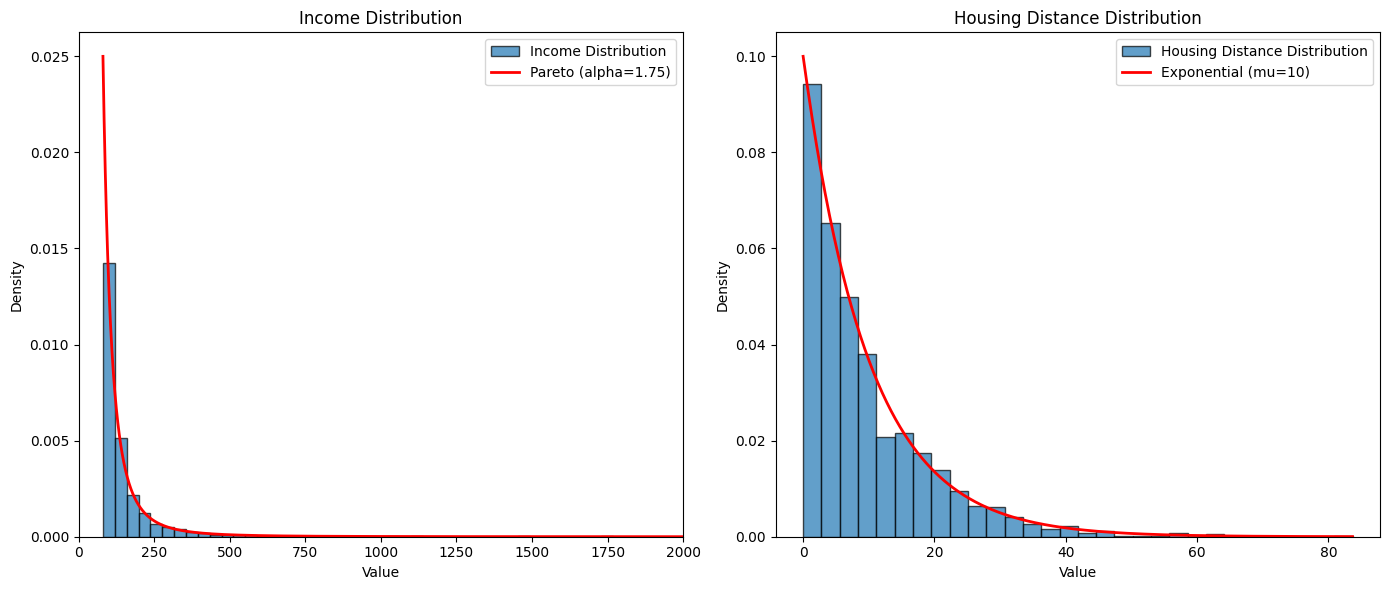

Income: [  80.05848087   80.05982259   80.06730364 ... 2050.74786547 3083.75325989
 4002.92007828]
Housing Distance: [7.99111210e-03 1.05101425e-02 1.45859840e-02 ... 6.24181090e+01
 6.28373459e+01 8.36793550e+01]


In [40]:

# PLOT DISTRIBUTIONS 

def plot_distributions(n,y_min,alpha,mu,c,seed,xlim):
    
    y,d,=gen_data(n, y_min, alpha, mu, c, seed)

    # check to see if they look pareto and exp
    
    plt.figure(figsize=(14, 6))  

    # Income Distribution
    plt.subplot(1, 2, 1)
    plt.hist(y, bins=100, density=True, alpha=0.7, edgecolor="black", label="Income Distribution")
    plt.title("Income Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.xlim(0, xlim) 

    # Add Pareto line
    pareto_x = np.linspace(y_min, xlim, xlim)
    pareto_pdf = (alpha * y_min**alpha) / (pareto_x ** (alpha + 1))
    plt.plot(pareto_x, pareto_pdf, 'r-', lw=2, label="Pareto (alpha=1.75)")
    plt.legend()

    # Housing Distance Distribution
    plt.subplot(1, 2, 2)
    plt.hist(d, bins=30, density=True, alpha=0.7, edgecolor="black", label="Housing Distance Distribution")
    plt.title("Housing Distance Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")

    # Add Exponential line
    exp_x = np.linspace(0, d.max(), 500)
    exp_pdf = (1 / mu) * np.exp(-exp_x / mu)
    plt.plot(exp_x, exp_pdf, 'r-', lw=2, label="Exponential (mu=10)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f'Income: {y}')
    print(f'Housing Distance: {d}')


# Generate samples for visualization
n_test = 2000
y_min_test = 80
alpha_test = 2
mu_test = 10
c_test = 50
seed = 1


plot_distributions(n_test,y_min_test,alpha_test,mu_test,c_test,seed,xlim=2000) #xlim for readibility



## Visualization and Statistics

In [41]:
def compute_statistics(prices):
    average = np.mean(prices)
    median = np.median(prices)
    Q1 = np.percentile(prices, 25)
    Q3 = np.percentile(prices, 75)
    IQR = Q3 - Q1

    statistics = {
        'average': average,
        'median': median,
        'Q1' : Q1,
        'Q3' : Q3,
        'IQR': IQR
    }

    return statistics


def plot_house_prices(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)

    plt.figure(figsize=(12, 6))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, color='b')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('House Price')
    plt.title('House Prices vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_percentage_income_spent(y, prices):
    n = len(y)
    income_quantiles = np.linspace(0, 1, n)
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_spent = np.where(y != 0, (prices / y) * 100, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(income_quantiles, percentage_spent, marker='s', linestyle='--', color='r')
    plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
    plt.ylabel('Percentage of Income Spent on Housing (%)')
    plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#plot_house_prices(y, prices)
#plot_percentage_income_spent(y, prices)
#print(compute_statistics(prices))

## 2a: basic recursion

In [42]:
def equilibrium_price_recursive(n, c, y, d, j):

    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")

    if j == 0:
        return c  # Base case: first house price is equal to c

    theta_j = np.exp(-(d[j] - d[j - 1]))
    # Recursive call for the previous house (j-1)
    previous_price = equilibrium_price_recursive(n, c, y, d, j - 1)
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    return equilibrium_price

def calc_prices_recursive(n, c, y, d):
    prices = []
    for j in range(n):
        prices.append(equilibrium_price_recursive(n, c, y, d, j))
    return np.array(prices)


## 2b: memo

In [43]:
def equillibrium_price_memo(n, c, y, d, j, memo=None):
    # Initialize memo array if not provided
    if memo is None:
        memo = np.full(n, np.nan)
    
    # Input validation
    if j < 0 or j >= n:
        raise ValueError(f"Invalid j: {j}. It should be between 0 and {n-1}.")
    
    # Check if value is already memoized
    if not np.isnan(memo[j]):
        return memo[j]
    
    # Base case: first house price
    if j == 0:
        memo[0] = c
        return c
    
    # Calculate theta_j
    theta_j = np.exp(-(d[j] - d[j - 1]))
    
    # Recursive call for previous house with memoization
    previous_price = equillibrium_price_memo(n, c, y, d, j - 1, memo)
    
    # Calculate and memoize current price
    equilibrium_price = theta_j * previous_price + (1 - theta_j) * y[j]
    memo[j] = equilibrium_price
    
    return equilibrium_price

def calc_price_memo(n, c, y, d):
    # Initialize memo array for the entire calculation
    memo = np.full(n, np.nan)
    prices = []
    for j in range(n):
        prices.append(equillibrium_price_memo(n, c, y, d, j, memo))
    return np.array(prices)

## 2c: Iteractive 

In [44]:
def calc_prices_iterative(n, c, y, d):
    prices = np.zeros(n)
    prices[0] = c  # Base case
    
    # Calculate prices iteratively
    for j in range(1, n):
        theta_j = np.exp(-(d[j] - d[j-1]))
        prices[j] = theta_j * prices[j-1] + (1 - theta_j) * y[j]
    
    return prices


## 4a

   y_min     average      median          Q1          Q3         IQR
0     80  185.611251  115.038701   87.792114  170.748685   82.956571
1    100  196.085954  137.642451  109.038461  200.511604   91.473143
2    150  309.485837  208.387101  160.501570  298.268985  137.767415


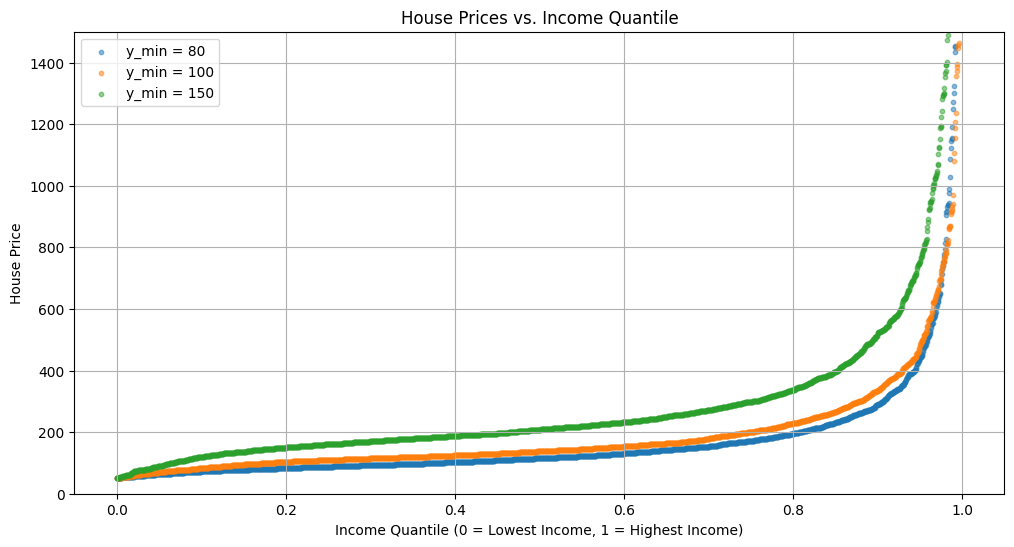

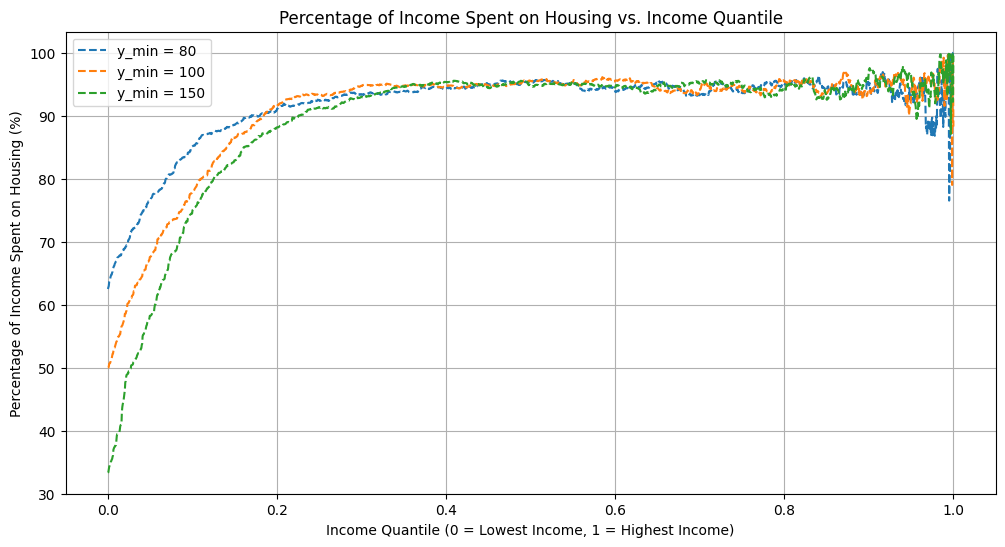

In [45]:
n = 2000
y_min_list = [80, 100, 150]
alpha = 1.75
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each y_min value
for y_min in y_min_list:
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
   
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['y_min'] = y_min  
    stats_list.append(stats)
    
    # Test base case
   # base_case_price = prices[0]  # This is the price of house j=1
   # if base_case_price == c:
   #     base_case_result = f"Base Case check passed: {base_case_price}"
  #  else:
   #     base_case_result = f"Base Case check failed: {base_case_price}"

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['y_min', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)


# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, y_min) in enumerate(zip(all_prices, y_min_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'y_min = {y_min}')
plt.ylim(0, 1500)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, y_min) in enumerate(zip(all_y, all_prices, y_min_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'y_min = {y_min}')

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()



### 4b

   alpha     average      median         Q1          Q3         IQR
0   1.25  344.744938  130.596420  91.058789  220.848825  129.790036
1   1.75  181.309709  113.849373  88.125267  169.029785   80.904517
2   3.00  115.471770   98.050745  84.144999  124.562424   40.417425


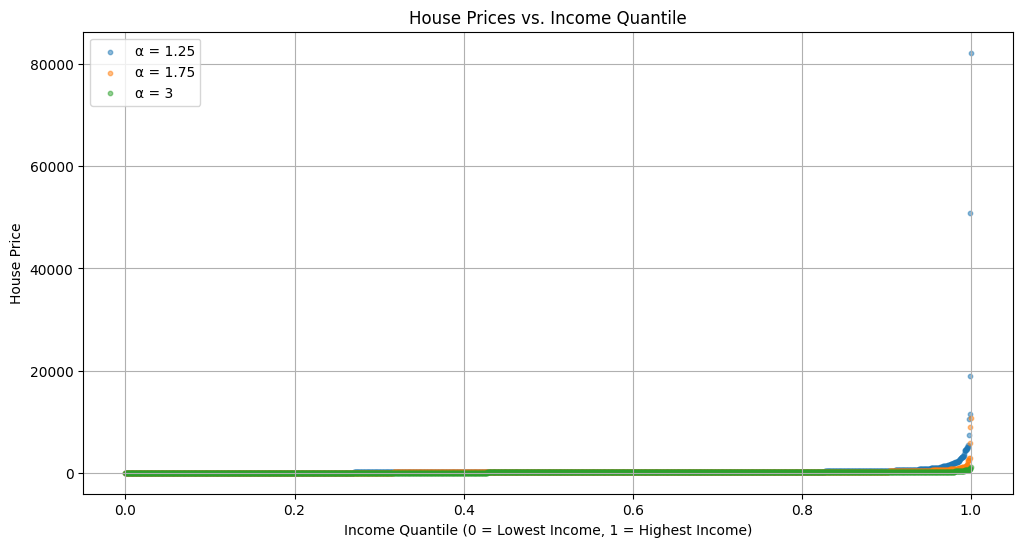

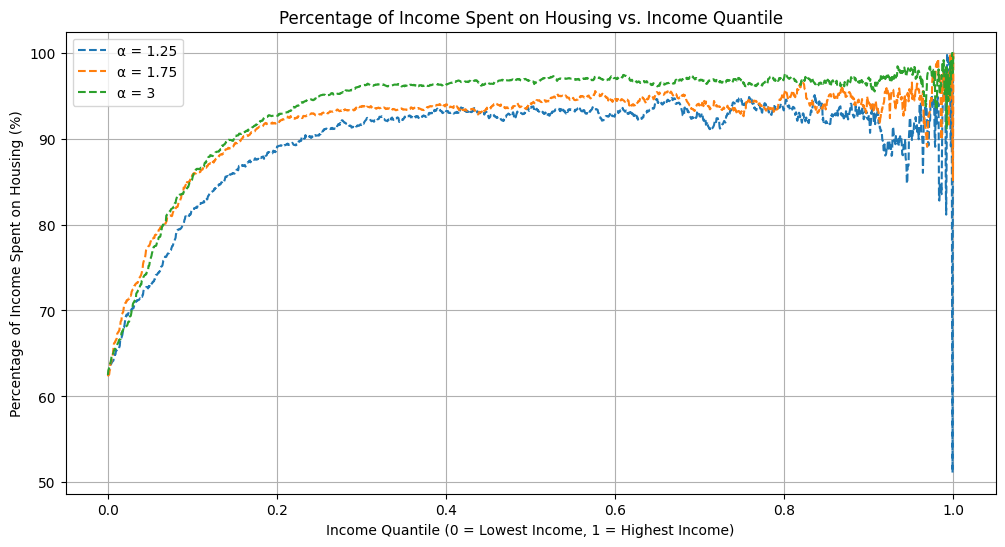

In [46]:
n = 2000
alpha_list = [1.25, 1.75, 3]
y_min = 80
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices

# Iterate over each alpha
for alpha in alpha_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['alpha'] = alpha  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['alpha', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, alpha) in enumerate(zip(all_prices, alpha_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {alpha}')  

#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, alpha) in enumerate(zip(all_y, all_prices, alpha_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {alpha}') 
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

### 4c

   mu     average      median         Q1          Q3        IQR
0   5  152.734149  104.279988  78.568659  155.827674  77.259015
1  10  170.023069  114.929725  88.654501  172.879022  84.224521
2  20  172.768476  113.675242  91.609042  171.538088  79.929046


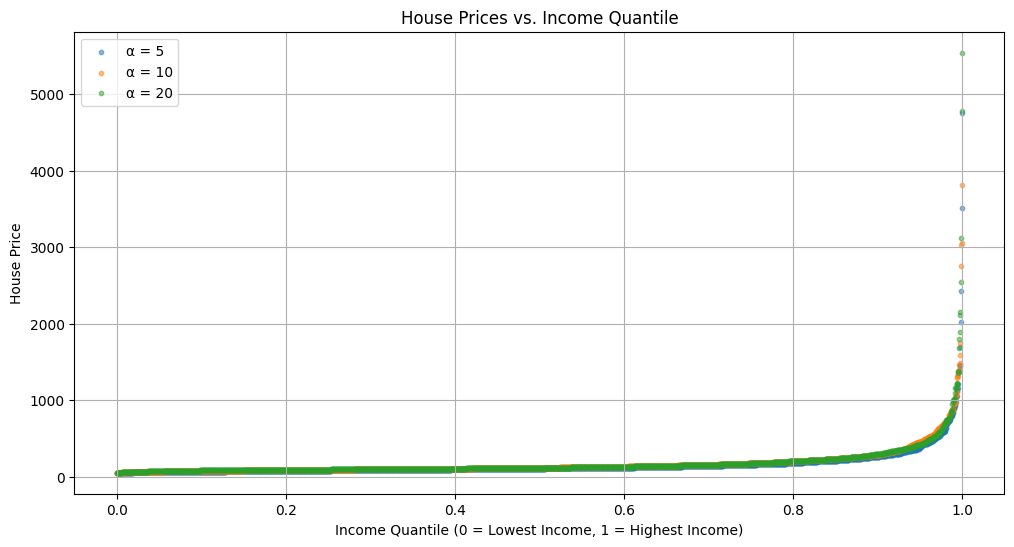

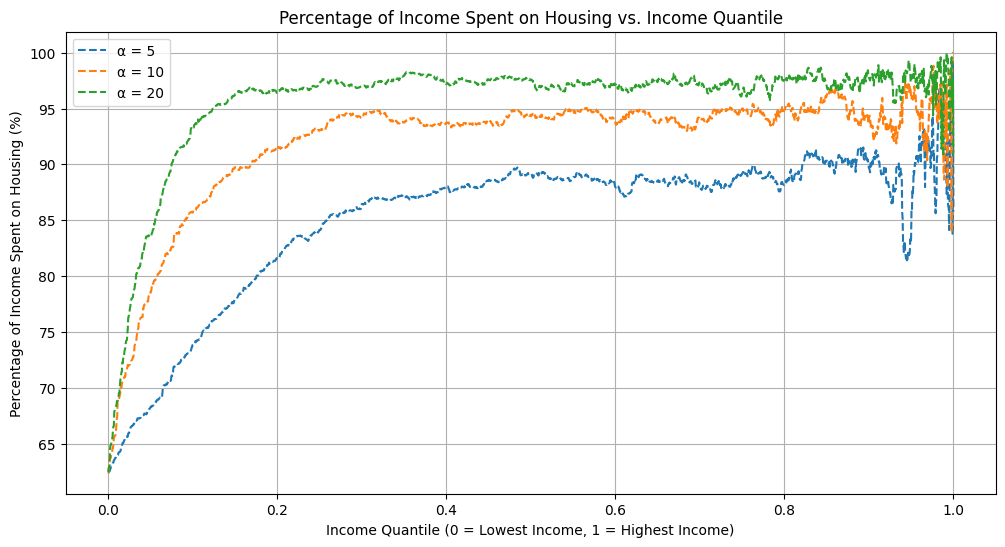

In [47]:
n = 2000
mu_list = [5,10,20]
y_min = 80
alpha = 1.75
c = 50
seed = 1

# Initialize lists to collect statistics and data
stats_list = []
all_y = []  # Store income data
all_prices = []  # Store price data

# Iterate over each alpha
for mu in mu_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store the data
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats = compute_statistics(prices)
    stats['mu'] = mu  
    stats_list.append(stats)

# df for table
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]  
print(stats_df)

# Create plots after the loop
income_quantiles = np.linspace(0, 1, n)

# First plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for i, (prices, mu) in enumerate(zip(all_prices, mu_list)):
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'α = {mu}') 
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for i, (y, prices, mu) in enumerate(zip(all_y, all_prices, mu_list)):
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'α = {mu}')  # Fixed: Label shows alpha
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Population Growth

## Building up

      n     average      median         Q1          Q3        IQR
0  2000  165.799297  112.756103  87.278192  170.050481  82.772289
1  4000  167.559396  111.805440  87.641093  166.062772  78.421679


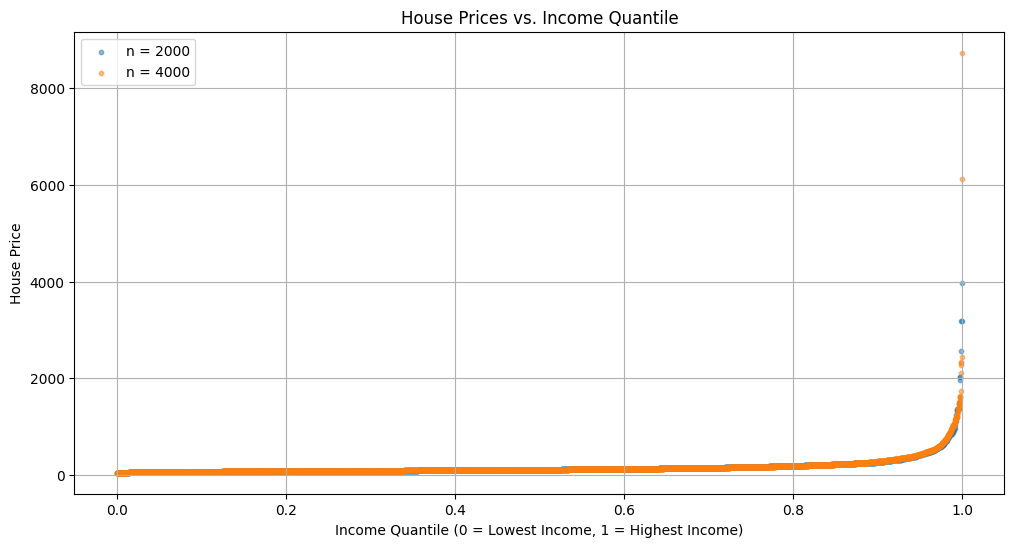

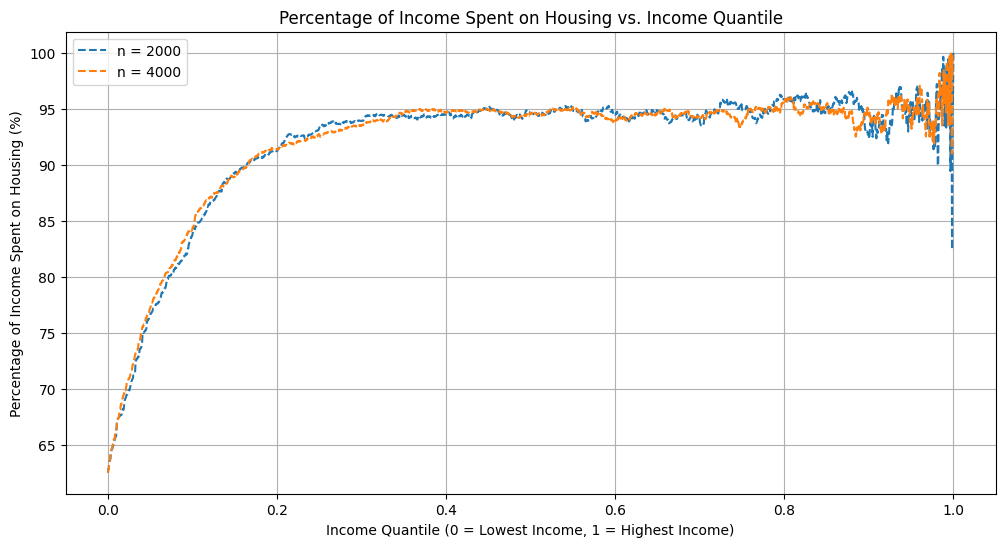

In [51]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
mu = 10
c = 50
seed = 1

stats_list = []  # Store stats for table
all_y = []        # Store income data
all_prices = []   # Store prices


for n in n_list:

    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d) # the regular recursive approach does not work with n=4000
    all_y.append(y)
    all_prices.append(prices)
    
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n  
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# Create plots after the loop

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, label=f'n = {n}')
#plt.ylim(0, 1000)
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', label=f'n = {n}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile')
plt.grid(True)
plt.legend()
plt.show()


## Building out

      n  mu     average      median         Q1          Q3        IQR
0  2000  10  184.713902  113.407880  88.269122  164.922091  76.652969
1  4000  20  182.088180  115.523331  91.526364  171.043716  79.517352


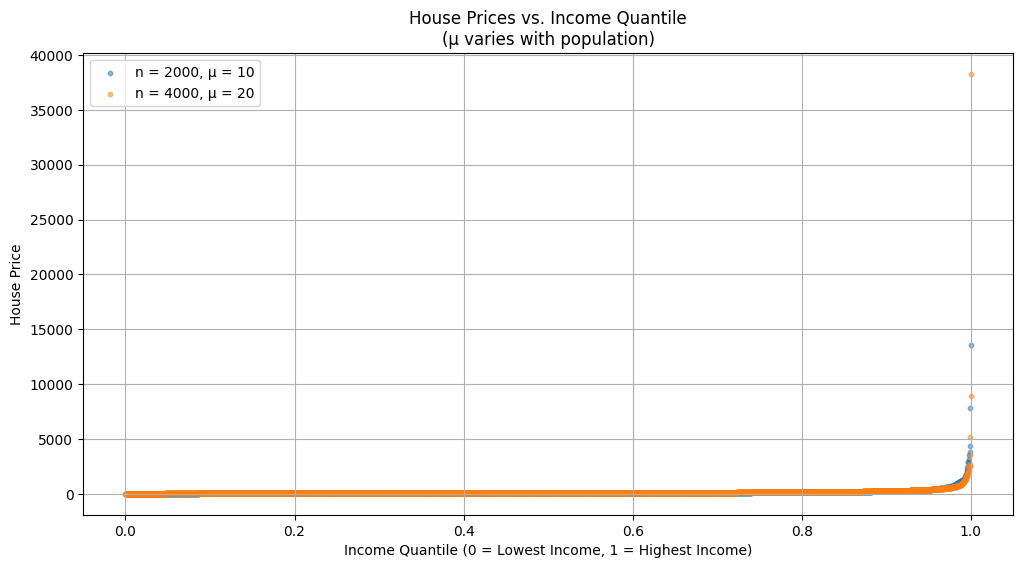

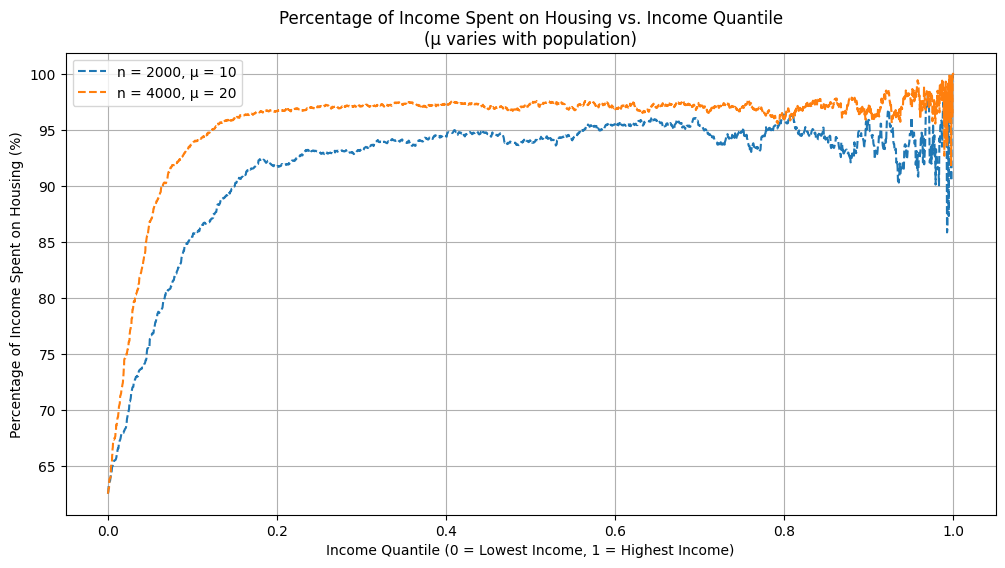

In [54]:
n_list = [2000, 4000]
alpha = 1.75
y_min = 80
c = 50
seed = 1
stats_list = []  # Store stats for table
all_y = []       # Store income data
all_prices = []  # Store prices

# Create dictionary mapping population sizes to mu values
mu_dict = {2000: 10, 4000: 20}  # mu doubles for larger population

for n in n_list:
    # Get appropriate mu for this population size
    mu = mu_dict[n]
    
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    all_y.append(y)
    all_prices.append(prices)
   
    # Compute statistics
    stats_i = compute_statistics(prices)
    stats_i['n'] = n
    stats_i['mu'] = mu  # Add mu to statistics for reference
    stats_list.append(stats_i)

# Create a DataFrame for statistics
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['n', 'mu', 'average', 'median', 'Q1', 'Q3', 'IQR']]
print(stats_df)

# First Plot: House Prices vs Income Quantile
plt.figure(figsize=(12, 6))
for prices, n in zip(all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    plt.scatter(income_quantiles, prices, s=10, alpha=0.5, 
                label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

# Second Plot: Percentage of Income Spent
plt.figure(figsize=(12, 6))
for y, prices, n in zip(all_y, all_prices, n_list):
    income_quantiles = np.linspace(0, 1, len(prices))
    percentage_spent = np.where(y != 0, (prices / y) * 100, 0)
    plt.plot(income_quantiles, percentage_spent, linestyle='--', 
             label=f'n = {n}, μ = {mu_dict[n]}')
plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('Percentage of Income Spent on Housing (%)')
plt.title('Percentage of Income Spent on Housing vs. Income Quantile\n(μ varies with population)')
plt.grid(True)
plt.legend()
plt.show()

## 7

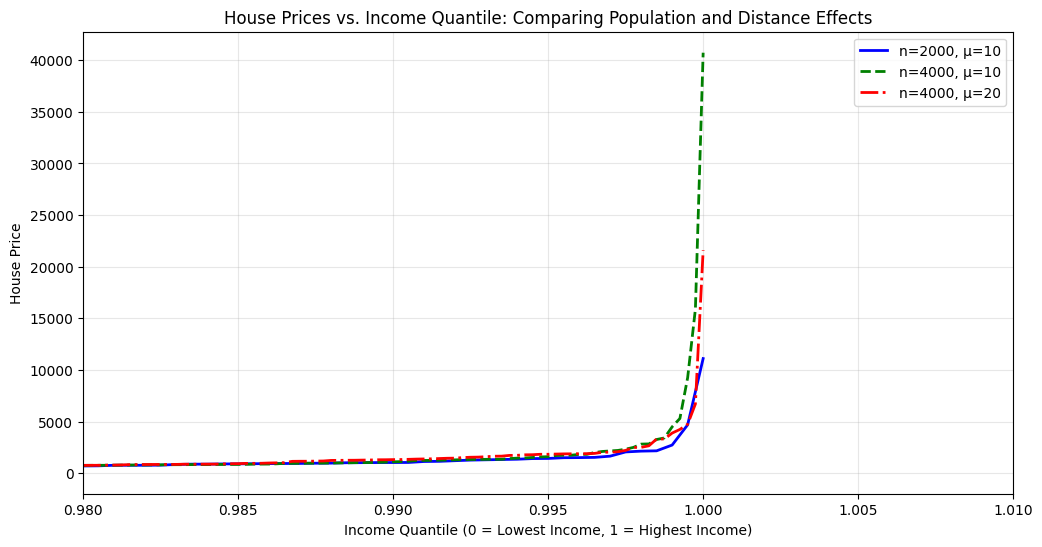

In [ ]:
scenarios = [
    {'n': 2000, 'mu': 10, 'label': 'n=2000, μ=10'},
    {'n': 4000, 'mu': 10, 'label': 'n=4000, μ=10'},
    {'n': 4000, 'mu': 20, 'label': 'n=4000, μ=20'}
]

# Constants
alpha = 1.75
y_min = 80
c = 50
seed = 1

# Store results
all_prices = []
all_quantiles = []

# Generate data for each scenario
for scenario in scenarios:
    n = scenario['n']
    mu = scenario['mu']
    
    # Generate data and calculate prices
    y, d = gen_data(n, y_min, alpha, mu, c)
    prices = calc_prices_iterative(n, c, y, d)
    
    # Store results
    all_prices.append(prices)
    all_quantiles.append(np.linspace(0, 1, len(prices)))

# Create single comparison plot
plt.figure(figsize=(12, 6))

# Plot each scenario with different line styles
styles = ['-', '--', '-.']
colors = ['blue', 'green', 'red']

for (prices, quantiles, scenario, style, color) in zip(all_prices, all_quantiles, scenarios, styles, colors):
    plt.plot(quantiles, prices, 
             linestyle=style,
             color=color,
             label=scenario['label'],
             linewidth=2)

plt.xlabel('Income Quantile (0 = Lowest Income, 1 = Highest Income)')
plt.ylabel('House Price')
plt.title('House Prices vs. Income Quantile: Comparing Population and Distance Effects')
plt.grid(True, alpha=0.3)
plt.legend()

plt.xlim(0.98, 1.01) # zoom in

plt.show()




## Running DocTest tests

This last step gets the DocTest system to check test cases in the documentation comments.
In this course, you won't need to modify the stuff below, or even understand the details.

In [ ]:
import doctest
result = doctest.testmod(verbose=False)
if result[0] == 0:
    print(("Congratulations! You have passed all "+str(result[1])+" tests"))
else:
    print("Rats!")

Congratulations! You have passed all 0 tests
